In [1]:
from typing import Dict, Union, List

import pandas as pd
import seaborn as sns
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kbgfibr9 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
df_reviews = pd.read_csv("../data/olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("../data/olist_orders_dataset.csv")
df_order_items = pd.read_csv("../data/olist_order_items_dataset.csv")

In [3]:
df_orders_reviews = pd.merge(df_orders, df_reviews, on='order_id')
df_orders_reviews_order_items = pd.merge(
    df_orders_reviews,
    df_order_items, on='order_id',
)

In [12]:
df = df_orders_reviews_order_items[['order_id', 'review_id', 'review_score', 'product_id']]
grouped_by_order = df.groupby(['order_id', 'review_id', 'review_score'])

In [13]:
score_by_product_id: Dict[str, Dict[str, Union[float, List[float]]]] = {}
for (order_id, review_id, review_score), order_rows in grouped_by_order:
    for product_id in {row[3] for row in order_rows.values}:
        if product_id not in score_by_product_id:
            score_by_product_id[product_id] = {
              'coef': 0,
              'score': 0,
              'coefs': [],
              'scores': [],
              'orders': [],
            }
        coef = np.count_nonzero(order_rows.values[:, 3] == product_id) / order_rows.shape[0]
        score_by_product_id[product_id]['coef'] += coef
        score_by_product_id[product_id]['score'] += coef * review_score
        # The following lines of codes add information used only for helping the user understand the finale score
        score_by_product_id[product_id]['coefs'].append(coef)
        score_by_product_id[product_id]['scores'].append(review_score)
        score_by_product_id[product_id]['orders'].append(order_id)

In [14]:
product_ids = []
product_scores = []
for product_id, score_data in score_by_product_id.items():
    score = score_data['score'] / score_data['coef']
    score_by_product_id[product_id]['score_final'] = score
    product_ids.append(product_id)
    product_scores.append(score)

In [15]:
scores = pd.DataFrame({'product_id': product_ids, 'score': product_scores})
scores.to_csv('../data/olist_product_scores.csv', index=False)

<AxesSubplot:xlabel='Count', ylabel='score'>

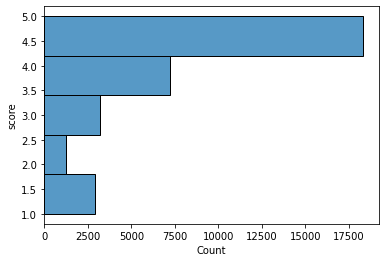

In [16]:
sns.histplot(data=scores, y='score', bins=5)#.get_figure().savefig('data/oslint_product_scores_histplot')

In [17]:
bad_products = scores[scores['score'] < 2]
bad_products = bad_products[bad_products['score'] > 1]
bad_products

In [23]:
example_data = score_by_product_id['1065e0ebef073787a7bf691924c60eeb']
example_data

{'coef': 2.1,
 'score': 2.3,
 'coefs': [0.1, 1.0, 1.0],
 'scores': [3, 1, 1],
 'orders': ['ca3625898fbd48669d50701aba51cd5f',
  'cd002226356c8056b3e5d2ab6098543f',
  'e8373fd2805212d0bc74790901dc446c'],
 'score_final': 1.0952380952380951}

In [40]:
df_orders_reviews = pd.merge(df_orders, df_orders_reviews[df_orders_reviews['order_id'].isin(example_data['orders'])], on='order_id')
df_orders_reviews_order_items = pd.merge(
    df_orders_reviews,
    df_order_items, on='order_id',
)[['order_id', 'review_id', 'review_score', 'review_comment_title', 'product_id']]
grouped_by_order = df_orders_reviews_order_items.groupby(['order_id'])

In [42]:
for order_id in example_data['orders']:
  print(grouped_by_order.get_group(order_id)[['review_score', 'review_comment_title', 'product_id']])

    review_score review_comment_title                        product_id
1              3                  NaN  1065e0ebef073787a7bf691924c60eeb
2              3                  NaN  0cf2faf9749f53924cea652a09d8e327
3              3                  NaN  0de59eddc63167215c972b0d785ffa7b
4              3                  NaN  0de59eddc63167215c972b0d785ffa7b
5              3                  NaN  5dae498eff2d80057f56122235a36aff
6              3                  NaN  4a5c3967bfd3629fe07ef4d0cc8c3818
7              3                  NaN  678c229b41c0e497d35a25a8be1cc631
8              3                  NaN  21b524c4c060169fa75ccf08c7da4627
9              3                  NaN  309dd69eb83cea38c51709d62befe1a4
10             3                  NaN  309dd69eb83cea38c51709d62befe1a4
    review_score       review_comment_title                        product_id
11             1  PRODUTO NÃO CHEGA NO PRAZ  1065e0ebef073787a7bf691924c60eeb
   review_score review_comment_title                

In [46]:
score_by_product_id['21b524c4c060169fa75ccf08c7da4627']

{'coef': 1.1,
 'score': 4.3,
 'coefs': [1.0, 0.1],
 'scores': [4, 3],
 'orders': ['77197d80101ec8ad66a1e174eea411e4',
  'ca3625898fbd48669d50701aba51cd5f'],
 'score_final': 3.9090909090909087}